In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
import seaborn as sns
from collections import Counter
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)
# https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot-in-matplotlibmatplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("train.csv")
train_dict = pd.read_csv("train_data_dict.csv")
df_test = pd.read_csv("test.csv")
samp = pd.read_csv("sample_submission_lfbv3c3.csv")

In [3]:
df_train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [4]:
df_train.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [5]:
df_test.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                              35
patientid                               0
City_Code_Patient                    2157
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
dtype: int64

In [6]:
df_train.shape

(318438, 18)

In [7]:
df_train['Stay'].unique()

array(['0-10', '41-50', '31-40', '11-20', '51-60', '21-30', '71-80',
       'More than 100 Days', '81-90', '61-70', '91-100'], dtype=object)

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
df_train['Stay'] = le.fit_transform(df_train['Stay'])

In [9]:
df_train['Stay'].value_counts()

2     87491
1     78139
3     55159
5     35018
0     23604
4     11743
7     10254
10     6683
8      4838
9      2765
6      2744
Name: Stay, dtype: int64

In [10]:
df_train['train_flag'] = 1
df_test['train_flag'] = 0
df_test['Stay'] = None
print(df_train.shape, df_test.shape)

df_data = pd.concat((df_train, df_test))
print(df_data.shape)

(318438, 19) (137057, 19)
(455495, 19)


In [11]:
df_data.drop(['case_id','patientid'],axis=1,inplace=True)

In [12]:
df_train.dtypes

case_id                                int64
Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
patientid                              int64
City_Code_Patient                    float64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                   int32
train_flag                             int64
dtype: object

In [13]:
df_data['Bed Grade'] = np.where(df_data['Bed Grade'].isna(),1.0,df_data['Bed Grade'])

In [14]:
df_data['City_Code_Patient'] = np.where(df_data['City_Code_Patient'].isna(),0.0,df_data['City_Code_Patient'])

In [15]:
df_data['Bed Grade'] = df_data['Bed Grade'].astype(int)
df_data['City_Code_Patient'] = df_data['City_Code_Patient'].astype(int)
df_data['Admission_Deposit'] = df_data['Admission_Deposit'].astype(int)


In [16]:
df_data.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,train_flag
0,8,c,3,Z,3,radiotherapy,R,F,2,7,Emergency,Extreme,2,51-60,4911,0,1
1,2,c,5,Z,2,radiotherapy,S,F,2,7,Trauma,Extreme,2,51-60,5954,4,1
2,10,e,1,X,2,anesthesia,S,E,2,7,Trauma,Extreme,2,51-60,4745,3,1
3,26,b,2,Y,2,radiotherapy,R,D,2,7,Trauma,Extreme,2,51-60,7272,4,1
4,26,b,2,Y,2,radiotherapy,S,D,2,7,Trauma,Extreme,2,51-60,5558,4,1


In [17]:
df_data.shape

(455495, 17)

In [18]:
df_data.columns

Index(['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'City_Code_Patient', 'Type of Admission', 'Severity of Illness',
       'Visitors with Patient', 'Age', 'Admission_Deposit', 'Stay',
       'train_flag'],
      dtype='object')

In [19]:
cat=df_data.select_dtypes(['object']).columns
cat

Index(['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type',
       'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age',
       'Stay'],
      dtype='object')

In [20]:
cat=cat[:-1]
cat

Index(['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type',
       'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness',
       'Age'],
      dtype='object')

In [21]:
df_data = pd.get_dummies(data=df_data,columns=['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type',
       'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness',
       'Age'])

In [22]:
df_data.shape

(455495, 53)

In [23]:
df_data.dtypes

Hospital_code                         int64
City_Code_Hospital                    int64
Available Extra Rooms in Hospital     int64
Bed Grade                             int32
City_Code_Patient                     int32
Visitors with Patient                 int64
Admission_Deposit                     int32
Stay                                 object
train_flag                            int64
Hospital_type_code_a                  uint8
Hospital_type_code_b                  uint8
Hospital_type_code_c                  uint8
Hospital_type_code_d                  uint8
Hospital_type_code_e                  uint8
Hospital_type_code_f                  uint8
Hospital_type_code_g                  uint8
Hospital_region_code_X                uint8
Hospital_region_code_Y                uint8
Hospital_region_code_Z                uint8
Department_TB & Chest disease         uint8
Department_anesthesia                 uint8
Department_gynecology                 uint8
Department_radiotherapy         

In [24]:
df_train, df_test = df_data[df_data.train_flag == 1], df_data[df_data.train_flag == 0]

In [25]:
df_train.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['Stay'], inplace=True, axis=1)

In [26]:
print(df_train.shape, df_test.shape)

(318438, 52) (137057, 51)


In [27]:
del df_data

In [28]:
df_train['Stay'] = df_train['Stay'].astype(int)

In [29]:
df_train, df_eval = train_test_split(df_train, test_size=0.30, random_state=42, shuffle=True, stratify=df_train['Stay'])

In [30]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('Stay')
#feature_cols.remove('Admission_Deposit')
label_col = 'Stay'
print(feature_cols)

['Hospital_code', 'City_Code_Hospital', 'Available Extra Rooms in Hospital', 'Bed Grade', 'City_Code_Patient', 'Visitors with Patient', 'Admission_Deposit', 'Hospital_type_code_a', 'Hospital_type_code_b', 'Hospital_type_code_c', 'Hospital_type_code_d', 'Hospital_type_code_e', 'Hospital_type_code_f', 'Hospital_type_code_g', 'Hospital_region_code_X', 'Hospital_region_code_Y', 'Hospital_region_code_Z', 'Department_TB & Chest disease', 'Department_anesthesia', 'Department_gynecology', 'Department_radiotherapy', 'Department_surgery', 'Ward_Type_P', 'Ward_Type_Q', 'Ward_Type_R', 'Ward_Type_S', 'Ward_Type_T', 'Ward_Type_U', 'Ward_Facility_Code_A', 'Ward_Facility_Code_B', 'Ward_Facility_Code_C', 'Ward_Facility_Code_D', 'Ward_Facility_Code_E', 'Ward_Facility_Code_F', 'Type of Admission_Emergency', 'Type of Admission_Trauma', 'Type of Admission_Urgent', 'Severity of Illness_Extreme', 'Severity of Illness_Minor', 'Severity of Illness_Moderate', 'Age_0-10', 'Age_11-20', 'Age_21-30', 'Age_31-40', '

In [31]:
cat_cols = feature_cols
cat_cols.remove('Admission_Deposit')
cat_cols

['Hospital_code',
 'City_Code_Hospital',
 'Available Extra Rooms in Hospital',
 'Bed Grade',
 'City_Code_Patient',
 'Visitors with Patient',
 'Hospital_type_code_a',
 'Hospital_type_code_b',
 'Hospital_type_code_c',
 'Hospital_type_code_d',
 'Hospital_type_code_e',
 'Hospital_type_code_f',
 'Hospital_type_code_g',
 'Hospital_region_code_X',
 'Hospital_region_code_Y',
 'Hospital_region_code_Z',
 'Department_TB & Chest disease',
 'Department_anesthesia',
 'Department_gynecology',
 'Department_radiotherapy',
 'Department_surgery',
 'Ward_Type_P',
 'Ward_Type_Q',
 'Ward_Type_R',
 'Ward_Type_S',
 'Ward_Type_T',
 'Ward_Type_U',
 'Ward_Facility_Code_A',
 'Ward_Facility_Code_B',
 'Ward_Facility_Code_C',
 'Ward_Facility_Code_D',
 'Ward_Facility_Code_E',
 'Ward_Facility_Code_F',
 'Type of Admission_Emergency',
 'Type of Admission_Trauma',
 'Type of Admission_Urgent',
 'Severity of Illness_Extreme',
 'Severity of Illness_Minor',
 'Severity of Illness_Moderate',
 'Age_0-10',
 'Age_11-20',
 'Age_21

In [32]:
label_col, len(feature_cols), len(cat_cols)

('Stay', 50, 50)

In [33]:
params = {}
params['learning_rate'] = 0.06
params['max_depth'] = 50
params['n_estimators'] = 500
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.6
params['reg_lambda'] = 1.1

In [34]:
clf = lgb.LGBMClassifier(**params)
    
clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=100, eval_set=[(df_train[feature_cols], df_train[label_col]), (df_eval[feature_cols], df_eval[label_col])], eval_metric='multi_error', verbose=True, categorical_feature=cat_cols)

eval_score = accuracy_score(df_eval[label_col], clf.predict(df_eval[feature_cols]))

print('Eval ACC: {}'.format(eval_score))

[1]	valid_0's multi_error: 0.725247	valid_0's multi_logloss: 1.88249	valid_1's multi_error: 0.725254	valid_1's multi_logloss: 1.88292
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_error: 0.722708	valid_0's multi_logloss: 1.86117	valid_1's multi_error: 0.722941	valid_1's multi_logloss: 1.86213
[3]	valid_0's multi_error: 0.716374	valid_0's multi_logloss: 1.84179	valid_1's multi_error: 0.716315	valid_1's multi_logloss: 1.8431
[4]	valid_0's multi_error: 0.707464	valid_0's multi_logloss: 1.8299	valid_1's multi_error: 0.707334	valid_1's multi_logloss: 1.83152
[5]	valid_0's multi_error: 0.700708	valid_0's multi_logloss: 1.81378	valid_1's multi_error: 0.70099	valid_1's multi_logloss: 1.8158
[6]	valid_0's multi_error: 0.692238	valid_0's multi_logloss: 1.80049	valid_1's multi_error: 0.69247	valid_1's multi_logloss: 1.80267
[7]	valid_0's multi_error: 0.684634	valid_0's multi_logloss: 1.78821	valid_1's multi_error: 0.685299	valid_1's multi_logloss: 1.79067
[8]	v

[62]	valid_0's multi_error: 0.578562	valid_0's multi_logloss: 1.54721	valid_1's multi_error: 0.584202	valid_1's multi_logloss: 1.56433
[63]	valid_0's multi_error: 0.578105	valid_0's multi_logloss: 1.54569	valid_1's multi_error: 0.584056	valid_1's multi_logloss: 1.56305
[64]	valid_0's multi_error: 0.578185	valid_0's multi_logloss: 1.54448	valid_1's multi_error: 0.584035	valid_1's multi_logloss: 1.56206
[65]	valid_0's multi_error: 0.578087	valid_0's multi_logloss: 1.54295	valid_1's multi_error: 0.58394	valid_1's multi_logloss: 1.56077
[66]	valid_0's multi_error: 0.577966	valid_0's multi_logloss: 1.54152	valid_1's multi_error: 0.583574	valid_1's multi_logloss: 1.55956
[67]	valid_0's multi_error: 0.577777	valid_0's multi_logloss: 1.54041	valid_1's multi_error: 0.58349	valid_1's multi_logloss: 1.55871
[68]	valid_0's multi_error: 0.577517	valid_0's multi_logloss: 1.53907	valid_1's multi_error: 0.583459	valid_1's multi_logloss: 1.5576
[69]	valid_0's multi_error: 0.577364	valid_0's multi_loglo

[123]	valid_0's multi_error: 0.569576	valid_0's multi_logloss: 1.49809	valid_1's multi_error: 0.580099	valid_1's multi_logloss: 1.52928
[124]	valid_0's multi_error: 0.569509	valid_0's multi_logloss: 1.49765	valid_1's multi_error: 0.579869	valid_1's multi_logloss: 1.52903
[125]	valid_0's multi_error: 0.569433	valid_0's multi_logloss: 1.49723	valid_1's multi_error: 0.57991	valid_1's multi_logloss: 1.52881
[126]	valid_0's multi_error: 0.56924	valid_0's multi_logloss: 1.49674	valid_1's multi_error: 0.579743	valid_1's multi_logloss: 1.52851
[127]	valid_0's multi_error: 0.569119	valid_0's multi_logloss: 1.49626	valid_1's multi_error: 0.579701	valid_1's multi_logloss: 1.52828
[128]	valid_0's multi_error: 0.569123	valid_0's multi_logloss: 1.49578	valid_1's multi_error: 0.57991	valid_1's multi_logloss: 1.52801
[129]	valid_0's multi_error: 0.56893	valid_0's multi_logloss: 1.49536	valid_1's multi_error: 0.579795	valid_1's multi_logloss: 1.52778
[130]	valid_0's multi_error: 0.568791	valid_0's mult

[183]	valid_0's multi_error: 0.564283	valid_0's multi_logloss: 1.47602	valid_1's multi_error: 0.579272	valid_1's multi_logloss: 1.52006
[184]	valid_0's multi_error: 0.56435	valid_0's multi_logloss: 1.47573	valid_1's multi_error: 0.579094	valid_1's multi_logloss: 1.51999
[185]	valid_0's multi_error: 0.564175	valid_0's multi_logloss: 1.47545	valid_1's multi_error: 0.579104	valid_1's multi_logloss: 1.51989
[186]	valid_0's multi_error: 0.564144	valid_0's multi_logloss: 1.47516	valid_1's multi_error: 0.579209	valid_1's multi_logloss: 1.51978
[187]	valid_0's multi_error: 0.563937	valid_0's multi_logloss: 1.47488	valid_1's multi_error: 0.57901	valid_1's multi_logloss: 1.51971
[188]	valid_0's multi_error: 0.563888	valid_0's multi_logloss: 1.4746	valid_1's multi_error: 0.578979	valid_1's multi_logloss: 1.51961
[189]	valid_0's multi_error: 0.563906	valid_0's multi_logloss: 1.47434	valid_1's multi_error: 0.579	valid_1's multi_logloss: 1.51956
[190]	valid_0's multi_error: 0.563771	valid_0's multi_

[244]	valid_0's multi_error: 0.559465	valid_0's multi_logloss: 1.4607	valid_1's multi_error: 0.578152	valid_1's multi_logloss: 1.51634
[245]	valid_0's multi_error: 0.559469	valid_0's multi_logloss: 1.46043	valid_1's multi_error: 0.578173	valid_1's multi_logloss: 1.51625
[246]	valid_0's multi_error: 0.559316	valid_0's multi_logloss: 1.46016	valid_1's multi_error: 0.578319	valid_1's multi_logloss: 1.51617
[247]	valid_0's multi_error: 0.559218	valid_0's multi_logloss: 1.45997	valid_1's multi_error: 0.578288	valid_1's multi_logloss: 1.51614
[248]	valid_0's multi_error: 0.559137	valid_0's multi_logloss: 1.45974	valid_1's multi_error: 0.578236	valid_1's multi_logloss: 1.51607
[249]	valid_0's multi_error: 0.55902	valid_0's multi_logloss: 1.45954	valid_1's multi_error: 0.578162	valid_1's multi_logloss: 1.51604
[250]	valid_0's multi_error: 0.558953	valid_0's multi_logloss: 1.45933	valid_1's multi_error: 0.578225	valid_1's multi_logloss: 1.51601
[251]	valid_0's multi_error: 0.558971	valid_0's mu

[306]	valid_0's multi_error: 0.554992	valid_0's multi_logloss: 1.4481	valid_1's multi_error: 0.577649	valid_1's multi_logloss: 1.51424
[307]	valid_0's multi_error: 0.554911	valid_0's multi_logloss: 1.44789	valid_1's multi_error: 0.577932	valid_1's multi_logloss: 1.51421
[308]	valid_0's multi_error: 0.554866	valid_0's multi_logloss: 1.44769	valid_1's multi_error: 0.577963	valid_1's multi_logloss: 1.51417
[309]	valid_0's multi_error: 0.55492	valid_0's multi_logloss: 1.44751	valid_1's multi_error: 0.577922	valid_1's multi_logloss: 1.51414
[310]	valid_0's multi_error: 0.554871	valid_0's multi_logloss: 1.44733	valid_1's multi_error: 0.57789	valid_1's multi_logloss: 1.51413
[311]	valid_0's multi_error: 0.554772	valid_0's multi_logloss: 1.44716	valid_1's multi_error: 0.577859	valid_1's multi_logloss: 1.51411
[312]	valid_0's multi_error: 0.554763	valid_0's multi_logloss: 1.44699	valid_1's multi_error: 0.578016	valid_1's multi_logloss: 1.51411
[313]	valid_0's multi_error: 0.554732	valid_0's mul

[368]	valid_0's multi_error: 0.551681	valid_0's multi_logloss: 1.43731	valid_1's multi_error: 0.57744	valid_1's multi_logloss: 1.51299
[369]	valid_0's multi_error: 0.551609	valid_0's multi_logloss: 1.43717	valid_1's multi_error: 0.57745	valid_1's multi_logloss: 1.51298
[370]	valid_0's multi_error: 0.55147	valid_0's multi_logloss: 1.43699	valid_1's multi_error: 0.577545	valid_1's multi_logloss: 1.51297
[371]	valid_0's multi_error: 0.551493	valid_0's multi_logloss: 1.43684	valid_1's multi_error: 0.577618	valid_1's multi_logloss: 1.51296
[372]	valid_0's multi_error: 0.551376	valid_0's multi_logloss: 1.4367	valid_1's multi_error: 0.577702	valid_1's multi_logloss: 1.51295
[373]	valid_0's multi_error: 0.551318	valid_0's multi_logloss: 1.43656	valid_1's multi_error: 0.577733	valid_1's multi_logloss: 1.51294
[374]	valid_0's multi_error: 0.551192	valid_0's multi_logloss: 1.43638	valid_1's multi_error: 0.577649	valid_1's multi_logloss: 1.51293
[375]	valid_0's multi_error: 0.55117	valid_0's multi

[429]	valid_0's multi_error: 0.548325	valid_0's multi_logloss: 1.42784	valid_1's multi_error: 0.57767	valid_1's multi_logloss: 1.51222
[430]	valid_0's multi_error: 0.548231	valid_0's multi_logloss: 1.42768	valid_1's multi_error: 0.577566	valid_1's multi_logloss: 1.51222
[431]	valid_0's multi_error: 0.54815	valid_0's multi_logloss: 1.42748	valid_1's multi_error: 0.577545	valid_1's multi_logloss: 1.51217
[432]	valid_0's multi_error: 0.548128	valid_0's multi_logloss: 1.42731	valid_1's multi_error: 0.577566	valid_1's multi_logloss: 1.51216
[433]	valid_0's multi_error: 0.548038	valid_0's multi_logloss: 1.42715	valid_1's multi_error: 0.577461	valid_1's multi_logloss: 1.51216
[434]	valid_0's multi_error: 0.547966	valid_0's multi_logloss: 1.427	valid_1's multi_error: 0.577461	valid_1's multi_logloss: 1.51215
[435]	valid_0's multi_error: 0.547881	valid_0's multi_logloss: 1.42686	valid_1's multi_error: 0.577618	valid_1's multi_logloss: 1.51215
[436]	valid_0's multi_error: 0.547854	valid_0's mult

In [35]:
best_iter = clf.best_iteration_
params['n_estimators'] = best_iter
print(params)

{'learning_rate': 0.06, 'max_depth': 50, 'n_estimators': 356, 'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.6, 'reg_lambda': 1.1}


In [36]:
df_train = pd.concat((df_train, df_eval))

In [37]:
clf = lgb.LGBMClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='multi_error', verbose=False, categorical_feature=cat_cols)

eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

ACC: 0.4425696681928664


In [38]:
preds = clf.predict(df_test[feature_cols])
preds

array([2, 5, 2, ..., 1, 1, 5])

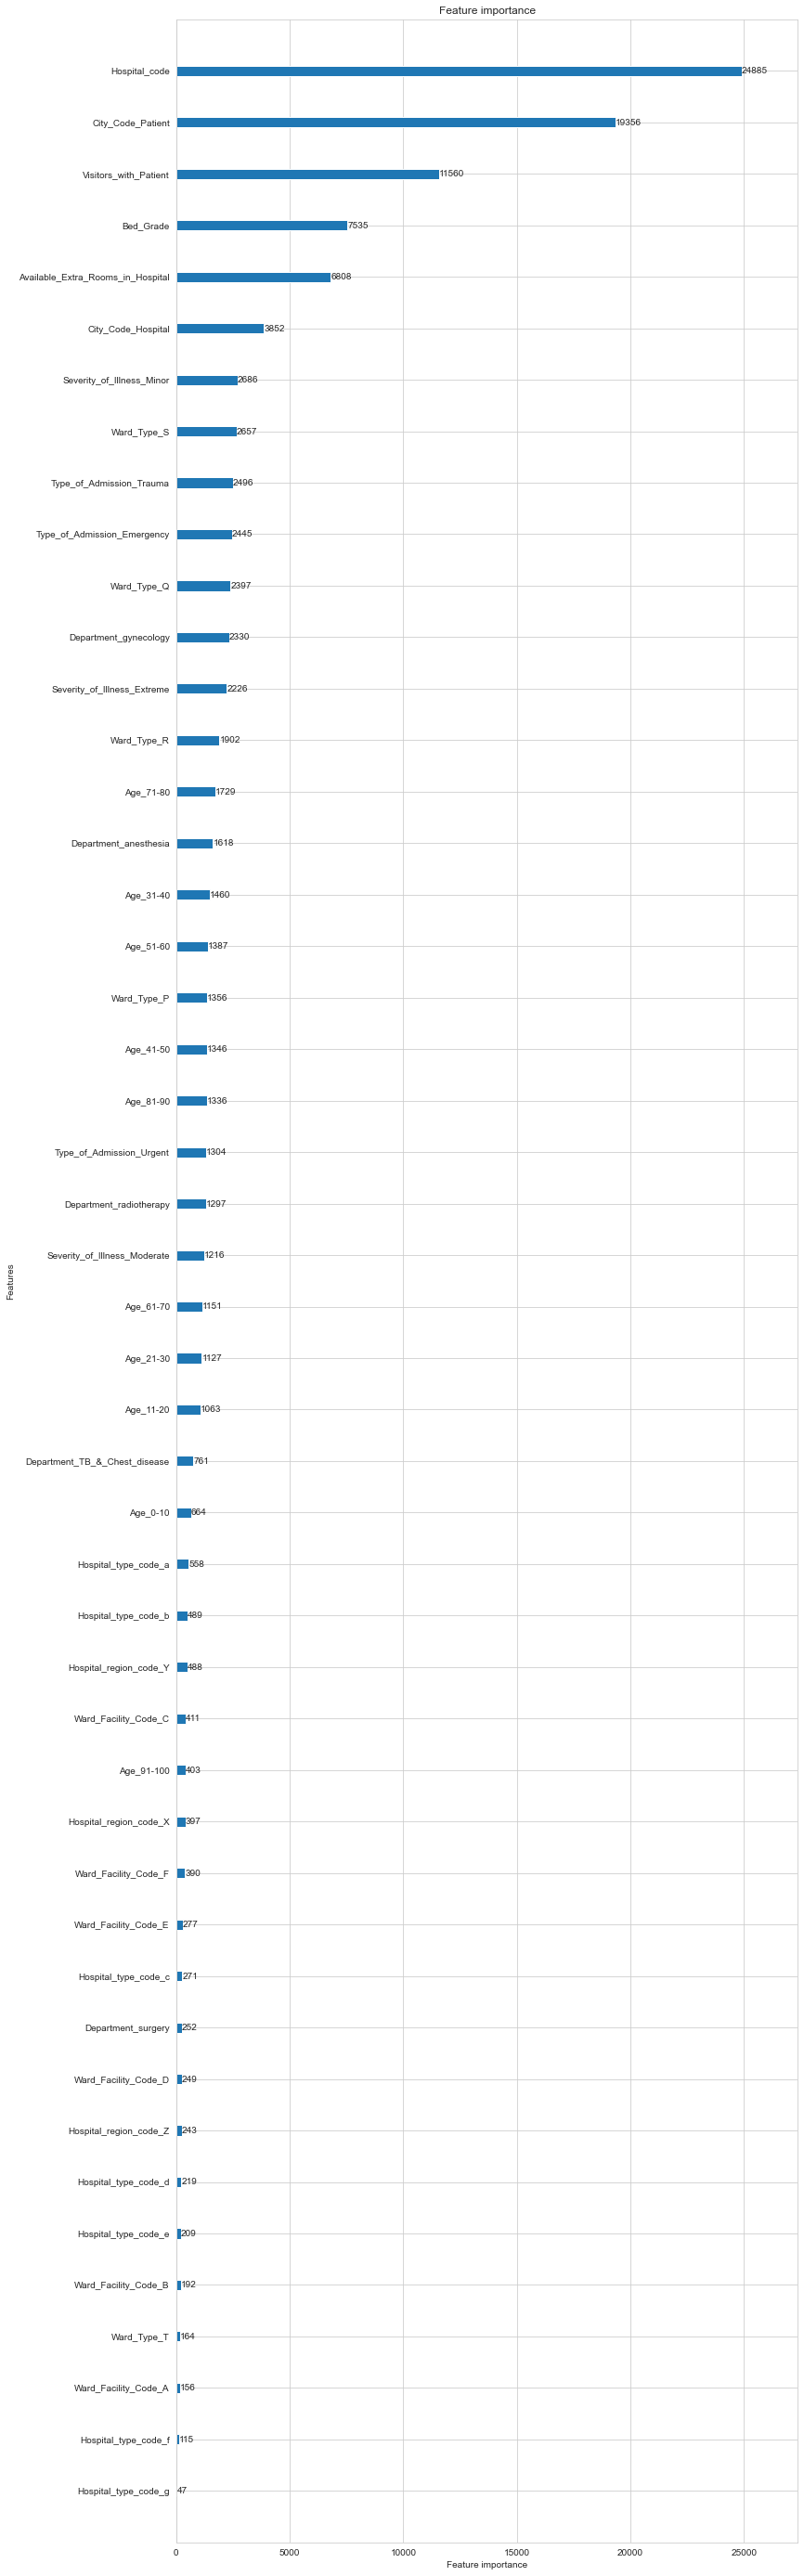

In [39]:
plt.rcParams['figure.figsize'] = (12,50)
lgb.plot_importance(clf)
plt.show()

In [40]:
preds = le.inverse_transform(preds)

In [41]:
preds

array(['21-30', '51-60', '21-30', ..., '11-20', '11-20', '51-60'],
      dtype=object)

In [42]:
test1 = pd.read_csv('test.csv')

In [43]:
submit = pd.DataFrame({'case_id': test1.case_id, 'Stay': preds})

In [44]:
submit.head()

,case_id,Stay
0,318439,21-30
1,318440,51-60
2,318441,21-30
3,318442,21-30
4,318443,51-60


In [45]:
submit.to_csv('submission-lgbm.csv', index=False)